# Stellar Scout: Model Evaluation and Comparison

## Setup

In [361]:
model_val_prob_preds = {}
model_val_preds = {}

### Imports

In [362]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, log_loss
from sklearn.calibration import calibration_curve
import torch
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_rows', 500)


### Load Data

In [363]:
df = pd.read_csv('data/final_data.csv')
df['status'].value_counts()

status
0    4561
1    2825
Name: count, dtype: int64

### Train / Test / Validation Splits

In [364]:
X = df.drop(columns=['status'])
y = df['status']

# 70/15/15 train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print("X:", X.shape, "X_train shape:", X_train.shape, "X_test shape:", X_test.shape, "X_val shape:", X_val.shape)

X: (7386, 7) X_train shape: (5170, 7) X_test shape: (1108, 7) X_val shape: (1108, 7)


## Linear / Logistic Regression

In [365]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs', 'sag']}
grid_search = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

lg_model = LogisticRegression(max_iter=5000, **best_params, random_state=0)

In [366]:
lg_model.fit(X_train, y_train)

model_val_prob_preds["Logistic Regression"] = lg_model.predict_proba(X_val)[:, 1]
model_val_preds["Logistic Regression"] = lg_model.predict(X_val)

## Decision Trees

### Bootstrap Aggregation

In [367]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2, max_depth= None, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [368]:
model_val_prob_preds["Random Forest"] = rf_model.predict_proba(X_val)[:, 1]
model_val_preds["Random Forest"] = rf_model.predict(X_val)

### Gradient Boosting

In [369]:
gb_model = GradientBoostingClassifier(n_estimators=300, max_depth= 10, random_state=0)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=300, random_state=0)

In [370]:
model_val_prob_preds["Gradient Boosting"] = gb_model.predict_proba(X_val)[:, 1]
model_val_preds["Gradient Boosting"] = gb_model.predict(X_val)

## Neural Network

In [371]:
def convert_to_tensor(X, y):
    # Convert to numpy arrays
    X_nn = np.array(X, dtype=np.float32)
    y_nn = np.array(y, dtype=np.float32).reshape(-1,1)

    # Convert to tensors
    X_nn = torch.tensor(X_nn, dtype=torch.float32)
    y_nn = torch.tensor(y_nn, dtype=torch.float32)

    return X_nn, y_nn

In [372]:
nn_features = ['orbital_period', 'transit_duration', 'equilibrium_temperature', 'stellar_effective_temperature', 'planet_radius_log', 'stellar_pca1', 'stellar_pca2']

device = torch.device("cpu")

nn_model = torch.load("successful_model.pt", map_location=device)
nn_model.eval()

X_val_tensor, y_val_tensor = convert_to_tensor(X_val, y_val)

X_val_tensor = X_val_tensor.to(device)

with torch.no_grad():
    y_val_pred = nn_model(X_val_tensor)

In [373]:
model_val_prob_preds["Neural Network"] = y_val_pred.cpu().numpy()

# Get predictions
y_val_pred_prob = y_val_pred.cpu().numpy()
y_val_pred = np.round(y_val_pred_prob).reshape(-1)
model_val_preds["Neural Network"] = y_val_pred.reshape(-1)

## Evaluation

### Log Loss

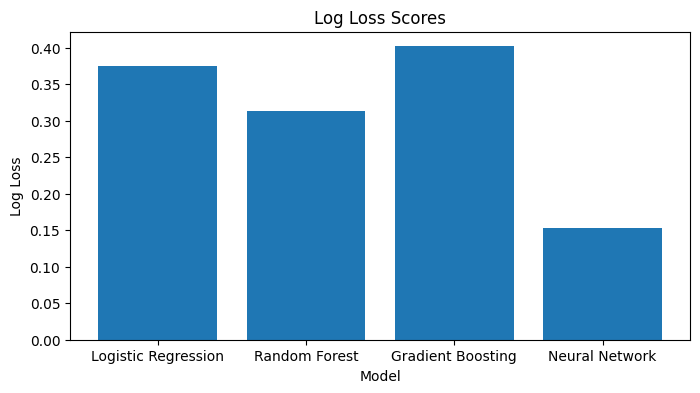

Log Loss Scores:
Logistic Regression : 0.37463501834354535
Random Forest : 0.31391237635903346
Gradient Boosting : 0.4020053593461947
Neural Network : 0.1524718294051144


In [374]:
log_loss_scores = {}

for model in model_val_prob_preds:
    log_loss_scores[model] = log_loss(y_val, model_val_prob_preds[model])

plt.figure(figsize=(8,4))
plt.bar(log_loss_scores.keys(), log_loss_scores.values())
plt.title("Log Loss Scores")
plt.ylabel("Log Loss")
plt.xlabel("Model")
plt.show()

print("Log Loss Scores:")
for model in log_loss_scores:
    print(model, ":", log_loss_scores[model])

### Accuracy

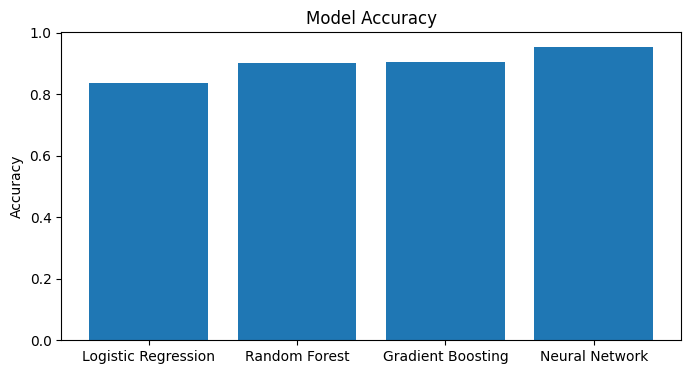

Accuracy Scores:
Logistic Regression : 0.8348375451263538
Random Forest : 0.9025270758122743
Gradient Boosting : 0.9034296028880866
Neural Network : 0.9530685920577617


In [375]:
accuracy_scores = {}

for model in model_val_preds:
    accuracy_scores[model] = accuracy_score(y_val, model_val_preds[model])

plt.figure(figsize=(8, 4))
plt.bar(accuracy_scores.keys(), accuracy_scores.values())
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.show()

print("Accuracy Scores:")
for model in accuracy_scores:
    print(model, ":", accuracy_scores[model])

### ROC Curve

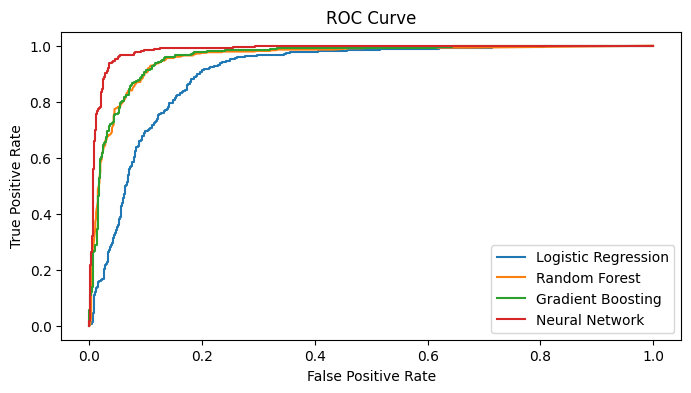

In [376]:
plt.figure(figsize=(8, 4))
for model in model_val_prob_preds:
    fpr, tpr, _ = roc_curve(y_val, model_val_prob_preds[model])
    plt.plot(fpr, tpr, label=model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Calibration Curve

In [377]:
def plot_calibration_curves(calibration_curves):
    plt.figure(figsize=(8, 6))

    for model in calibration_curves:
        y_true, y_prob = calibration_curves[model]
        plt.plot(y_prob, y_true, 's-', label=model, alpha=0.75)

    plt.plot([0, 1], [0, 1], color='gray', label='Ideal calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

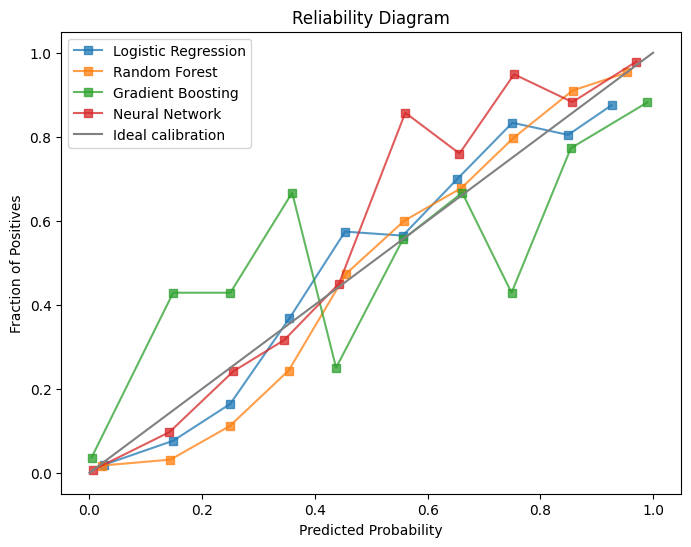

In [378]:
calibration_data = {}

for model in model_val_prob_preds:
    calibration_data[model] = calibration_curve(y_val, model_val_prob_preds[model], n_bins=10)


plot_calibration_curves(calibration_data)

### Integrated Calibration Index

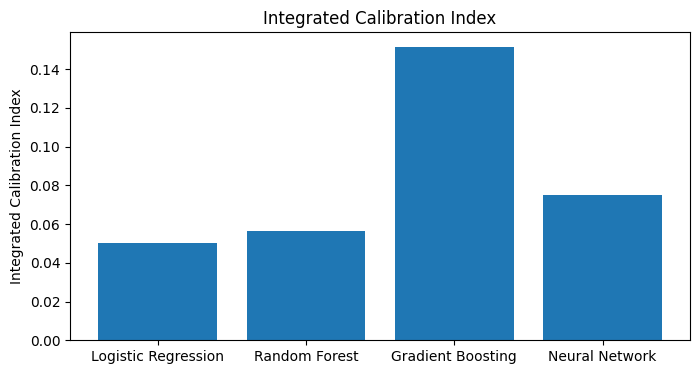

Integrated Calibration Index:
Logistic Regression : 0.05030198483475984
Random Forest : 0.05657647651963542
Gradient Boosting : 0.1514467266419024
Neural Network : 0.07514102531569834


In [379]:
from scipy import integrate

def integrated_calibration_index(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    ici = integrate.trapezoid(np.abs(prob_pred - prob_true), prob_pred)
    return ici

ici_scores = {}

for model in model_val_prob_preds:
    ici_scores[model] = integrated_calibration_index(y_val, model_val_prob_preds[model])

plt.figure(figsize=(8, 4))
plt.bar(ici_scores.keys(), ici_scores.values())
plt.ylabel("Integrated Calibration Index")
plt.title("Integrated Calibration Index")
plt.show()

print("Integrated Calibration Index:")
for model in ici_scores:
    print(model, ":", ici_scores[model])

In [ ]:
# Predict the candidate planets. See how many are out there.
